In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import copy
import torch.optim as optim
import tqdm
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

NUM_ATTRIBUTES = 78

In [3]:
data = pd.concat(map(pd.read_csv, ["../Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", 
                                 "../Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
                                 "../Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
                                 "../Friday-WorkingHours-Morning.pcap_ISCX.csv",
                                 "../Monday-WorkingHours.pcap_ISCX.csv",
                                 "../Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
                                 "../Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
                                 "../Tuesday-WorkingHours.pcap_ISCX.csv",
                                 "../Wednesday-workingHours.pcap_ISCX.csv"]))
# data = pd.read_csv("../Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", header=None)

X = data.iloc[:, 0:NUM_ATTRIBUTES] # obtain all instances and there columns except the last column
y = data.iloc[:, NUM_ATTRIBUTES:] # obtain all instances and only the last column (label)

X = X.drop(0) #gets rid of the first row (features names)
y = y.drop(0) #gets rid of the first row (label name - Label)
print("TOTAL ROWS PARSED: ", len(X.values)) # prints the total num of instances 

X_VALUES = (X.values).astype('float32') # converts all numbers into floating point values 32

if np.any(np.isinf(X_VALUES)) or np.any(np.isnan(X_VALUES)):
    print("Data contains infinite or NaN values")

X_VALUES = np.where(np.isinf(X_VALUES), np.nan, X_VALUES)

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')  # use the mean to fill the inf and nan values
X_VALUES = imputer.fit_transform(X_VALUES)

# np.savetxt('test1.txt', X_VALUES, fmt='%d') 

TOTAL ROWS PARSED:  3001100
Data contains infinite or NaN values


In [4]:
# # Splits the data into BENIGN and BAD packets evenly
# analysis_data = pd.DataFrame()

# malicious_count = 0
# normal_count = 0
# for i in range(len(data)):
#     if str(data.iloc[i, 78]) == "BENIGN" and normal_count <= malicious_count:
#         analysis_data = pd.concat([analysis_data, pd.DataFrame([data.iloc[i]])], ignore_index=True)
#         normal_count += 1
#     elif str(data.iloc[i, 78]) != "BENIGN" and malicious_count <= normal_count:
#         analysis_data = pd.concat([analysis_data, pd.DataFrame([data.iloc[i]])], ignore_index=True)
#         malicious_count += 1

# print(malicious_count)
# print(normal_count)

# X_z = analysis_data.iloc[:, 0:NUM_ATTRIBUTES] # obtain all instances and there columns except the last column
# y_z = analysis_data.iloc[:, NUM_ATTRIBUTES:] # obtain all instances and only the last column (label)

# X_VALUES_DISTRIBUTED = (X_z.values).astype('float32') # converts all numbers into floating point values 32

# # X_VALUES_DISTIBUTED[np.isnan(X_VALUES_DISTIBUTED)] = 0 #replaces all values of nan with 0
# # X_VALUES_DISTIBUTED[np.isinf(X_VALUES_DISTIBUTED)] = 0 #replaces all values of inf with 0

# # np.savetxt('distributed_dataset.csv', X_VALUES_DISTIBUTED, fmt='%d') 
# # np.savetxt('distributed_dataset.csv', ((analysis_data.iloc[:])), fmt='%d') 
# analysis_data.to_csv('distributed_dataset.csv', index=False)

In [5]:
# Transforms the y outputs to be encoded
# encode all the possible labels an instance can have
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
print(ohe.categories_)
 
# transform the y labels to be a digestible list 
# ex.) ['BENIGN', 'PortScan'] => [1. 0.] (means the instance has the label of BENIGN)
y = ohe.transform(y)
print("ALL POSSIBLE LABELS: ", y)
print("TOTAL LABELS: ",len(y[0]))
output_size = len(y[0])

[array(['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk',
       'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Heartbleed',
       'Infiltration', 'PortScan', 'SSH-Patator',
       'Web Attack � Brute Force', 'Web Attack � Sql Injection',
       'Web Attack � XSS'], dtype=object)]
ALL POSSIBLE LABELS:  [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
TOTAL LABELS:  15


In [6]:
# architecture of the network
class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_one = nn.Linear(78, 154) # seventy eight for all the input features and one hundred and fifty four for the expansion
        self.hidden_two = nn.Linear(154, 78) # another network layer
        self.act = nn.ReLU()
        self.output = nn.Linear(78, output_size) # output size is the appropriate y label
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.act(self.hidden_one(x)) 
        x = self.act(self.hidden_two(x))
        x = self.output(x)
        x = self.dropout(x)
        return x
    
model = Multiclass()

Below is how you can define the loss metric. The CrossEntropyLoss function in PyTorch combines the softmax function with the cross entropy calculation, so you don’t need any activation function at the output layer of your model. You also need an optimizer, and Adam is chosen below.

In [7]:
# obtain the loss function we will use (used to determine how good our model preforms)
loss_fn = nn.CrossEntropyLoss()
# optimizer used to improve our model
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 6002/6002 [00:36<00:00, 163.28batch/s, acc=0.788, loss=1.4e+3] 


Epoch 0 validation: Cross-entropy=2751.98, Accuracy=78.1% and Accuracy=78.1, F1 Score=78.1, Precision=78.1, Recall=78.1


Epoch 1: 100%|██████████| 6002/6002 [00:44<00:00, 134.52batch/s, acc=0.923, loss=1.68e+3]


Epoch 1 validation: Cross-entropy=1257.20, Accuracy=94.6% and Accuracy=94.6, F1 Score=94.6, Precision=94.6, Recall=94.6


Epoch 2: 100%|██████████| 6002/6002 [00:45<00:00, 133.16batch/s, acc=0.875, loss=446]    


Epoch 2 validation: Cross-entropy=762.89, Accuracy=92.9% and Accuracy=92.9, F1 Score=92.9, Precision=92.9, Recall=92.9


Epoch 3: 100%|██████████| 6002/6002 [00:44<00:00, 134.12batch/s, acc=0.83, loss=598]     


Epoch 3 validation: Cross-entropy=2046.65, Accuracy=82.5% and Accuracy=82.5, F1 Score=82.5, Precision=82.5, Recall=82.5


Epoch 4: 100%|██████████| 6002/6002 [00:51<00:00, 116.98batch/s, acc=0.938, loss=1.39e+3]


Epoch 4 validation: Cross-entropy=586.83, Accuracy=94.8% and Accuracy=94.8, F1 Score=94.8, Precision=94.8, Recall=94.8


Epoch 5: 100%|██████████| 6002/6002 [01:04<00:00, 92.98batch/s, acc=0.832, loss=372]     


Epoch 5 validation: Cross-entropy=2497.50, Accuracy=81.1% and Accuracy=81.1, F1 Score=81.1, Precision=81.1, Recall=81.1


Epoch 6: 100%|██████████| 6002/6002 [01:02<00:00, 96.18batch/s, acc=0.855, loss=295]     


Epoch 6 validation: Cross-entropy=427.96, Accuracy=95.2% and Accuracy=95.2, F1 Score=95.2, Precision=95.2, Recall=95.2


Epoch 7: 100%|██████████| 6002/6002 [01:07<00:00, 88.90batch/s, acc=0.827, loss=357]     


Epoch 7 validation: Cross-entropy=1710.65, Accuracy=83.3% and Accuracy=83.3, F1 Score=83.3, Precision=83.3, Recall=83.3


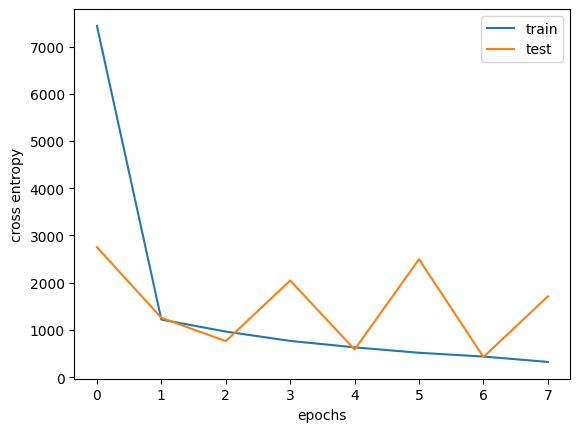

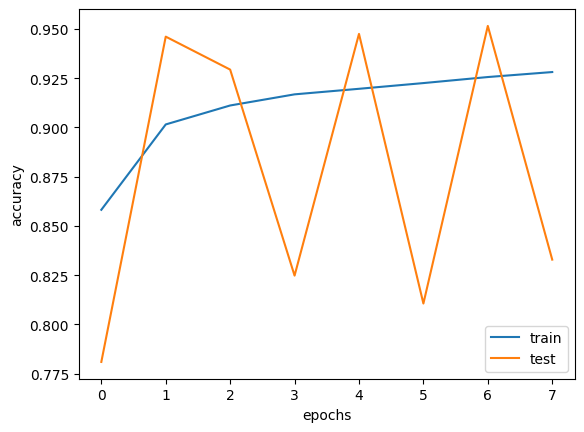

In [8]:
# convert pandas DataFrame features (X) and numpy array (y) into PyTorch tensors
X = torch.tensor(X_VALUES, dtype=torch.float32) # convert feature values into tensors
y = torch.tensor(y, dtype=torch.float32) # convert label values in tensors
 
#split the data into x training data (80% of feature data), x test data (20% of feature data), y training data (80% of label data),  y test data (20% of label data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True) 

# prepare model and training parameters
n_epochs = 8 # number of times we iterate over the data
batch_size = 275 # number of samples processed before an update is preformed
batches_per_epoch = len(X_train) // batch_size
# print(batches_per_epoch)
 
best_accuracy = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
 
# training loop
for epoch in range(n_epochs):
    epoch_loss = [] # keeps track of the overall loss
    epoch_acc = [] # keeps track of the accuracy after each iteration on the training data
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            accuracy = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            # f1 = f1_score(y_test, y_pred)
            # accuracy = accuracy_score(y_test, y_pred)
            epoch_loss.append(float(loss))
            epoch_acc.append(float(accuracy))
            bar.set_postfix(
                loss=float(loss),
                acc=float(accuracy)
            )
    # # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    y_pred_edit = torch.argmax(y_pred,axis=1)
    y_test_edit = torch.argmax(y_test,axis=1)
    loss = loss_fn(y_pred, y_test)
    f1 = f1_score(y_test_edit, y_pred_edit, average='micro')
    precision = precision_score(y_test_edit, y_pred_edit, average='micro')
    recall = recall_score(y_test_edit, y_pred_edit, average='micro')

    accuracy = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    accuracy_one = accuracy_score(y_test_edit, y_pred_edit)
    
    # accuracy = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    loss = float(loss)
    accuracy = float(accuracy)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(loss)
    test_acc_hist.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={loss:.2f}, Accuracy={accuracy * 100:.1f}% and Accuracy={accuracy_one * 100:.1f}, F1 Score={f1 * 100:.1f}, Precision={precision * 100:.1f}, Recall={recall * 100:.1f}")
 
# Restore best model
model.load_state_dict(best_weights)
 
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()
 
plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [9]:
# # saves the model to PATH variable
# PATH = './test_model.pth'
# torch.save(model.state_dict(), PATH)

In [10]:
# PATH = './test_model.pth'
# model = Multiclass() # initialize your model class
# model.load_state_dict(torch.load(PATH))

# # convert pandas DataFrame features (X) and numpy array (y) into PyTorch tensors
# X = torch.tensor(X_VALUES, dtype=torch.float32) # convert feature values into tensors
# y = torch.tensor(y, dtype=torch.float32) # convert label values in tensors
 
# #split the data into x training data (80% of feature data), x test data (20% of feature data), y training data (80% of label data),  y test data (20% of label data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)


# attack_test_count = 0
# benign_test_count = 0

# attack_array = []
# index_array = []

# # obtains the malicious instances
# for index, label in enumerate(y_test):
#     benign_test_count += 1
#     if False in torch.eq(torch.tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), label):
#         index_array.append(index)
#         attack_test_count += 1

# print(index_array)
# # loops through each malicious instance and tests it
# for index in index_array:
#     y_pred = model(X_test[index])
#     print(torch.argmax(y_pred) == torch.argmax(y_test[index]))
#     print(torch.argmax(y_pred))
#     print(torch.argmax(y_test[index]))
    


